# EE-411: Final project
## Reproducibility challenge: Reconciling modern machine learning practice and the bias-variance trade-off
### Defne Culha, Hector M. Ramírez C., Riselda Kodra and Valgerdur Jónsdóttir 

In this project, we will attempt to reproduce some of the results that are shown in the following paper: Reconciling modern machine learning practice and the bias-variance trade-off [1]. The paper introduces the concept of double descent, a phenomenon that seems to contradict the bias-variance trade-off in classical statistics, namely that having too many parameters, i.e., having a high model complexity, will yield an extremely large error. Modern machine learning techniques, such as neural networks, show that increasing the model complexity beyond a certain point of interpolation does in fact result in improved performance. The paper provides evidence for existence of double descent for a number of models and datasets, and in our reproduction of its results, we will focus on neural network and ensemble methods such as Random Forests.

[1] https://arxiv.org/abs/1812.11118

The paper's results will be reproduced for three types of models:
1. Fourier features model
2. Fully connected two-layer neural network
3. Random Forest model

Each team member is responsible for reproducing the results for one of the models, where Hector Ramírez worked on the Fourier features model, Defne Culha and Riselda Kodra worked on the neural network model, and Valgerdur Jónsdóttir worked on the Random Forest model. All teammembers were also flexible in helping each other with the reproduction of the results and the notebook and the written report were written collaboratively.

In [67]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils import data
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from torch.nn import MSELoss

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm

import sklearn
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import zero_one_loss
from sklearn.metrics import mean_squared_error

## MNIST: Importing the dataset

We import the data in two ways, first with a PyTorch implementation for the neural network approach and then with a scikit-learn implementation for the ensemble method approach.

### PyTorch implementation

We define a function that will load the MNIST training and test datasets. 

In [5]:
def get_mnist_data_pytorch():
    '''
    Return pytorch dataset object for the MNIST dataset 
    :return: train_dataset, test_dataset
    '''
    # load data
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
    return train_dataset, test_dataset

In [6]:
training_dataset, test_dataset = get_mnist_data_pytorch()
print("Number of training samples: ", len(training_dataset))
print("Number of test samples: ", len(test_dataset))

Number of training samples:  60000
Number of test samples:  10000


Here, we plot a few images in the training dataset.

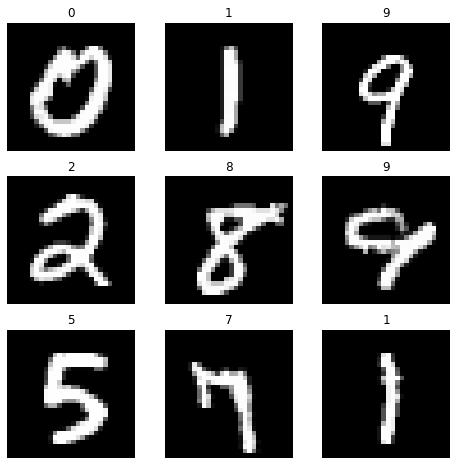

In [7]:
# plot the data
labels_map_minst = {
    0: "0",
    1: "1",
    2: "2",
    3: "3",
    4: "4",
    5: "5",
    6: "6",
    7: "7",
    8: "8",
    9: "9",
}

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_dataset), size=(1,)).item()
    img, label = training_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map_minst[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### scikit-learn implementation

For the scikit-learn implementation, we define a function that will load the MNIST training and test datasets from fetch_openml.

In [8]:
def get_mnist_data_sklearn(number_of_samples = 10000, split_percentage = 0.40):
    '''
    Return a subset of the MNIST dataset with the given number of samples
    :param number_of_samples: the number of samples to be returned
    :param split_percentage: the percentage of the data to be used for testing
    :return: X_train, X_test, y_train, y_test
    '''
    if (number_of_samples > 100000):
        raise Exception("Number of samples must be smaller than 100.000")
    X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
    X = X[:number_of_samples]
    y = y[:number_of_samples]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_percentage, random_state=42)
    
    return X_train, X_test, y_train, y_test

In [10]:
X_train, X_test, y_train, y_test = get_mnist_data_sklearn(10000, 0.40)
print("Number of training samples: ", len(X_train))
print("Number of test samples: ", len(X_test))
print("Number of train and test samples: ", len(X_train) + len(X_test))
print("Number of features: ", len(X_train[0]))
print("Number of classes: ", len(np.unique(y_train)))

Number of training samples:  6000
Number of test samples:  4000
Number of train and test samples:  10000
Number of features:  784
Number of classes:  10


Again, we plot a few images in the training dataset.

In [11]:
def plot_mnist_sklearn(X, y):
    '''
    Plot the first 9 images of the MNIST dataset
    :param X: the data
    :param y: the labels
    '''
    figure = plt.figure(figsize=(8, 8))
    cols, rows = 3, 3
    for i in range(1, cols * rows + 1):
        sample_idx = np.random.randint(len(X))
        img = X[sample_idx]
        label = y[sample_idx]
        figure.add_subplot(rows, cols, i)
        plt.title(label)
        plt.axis("off")
        plt.imshow(img.reshape(28,28), cmap="gray")
    plt.show()
        

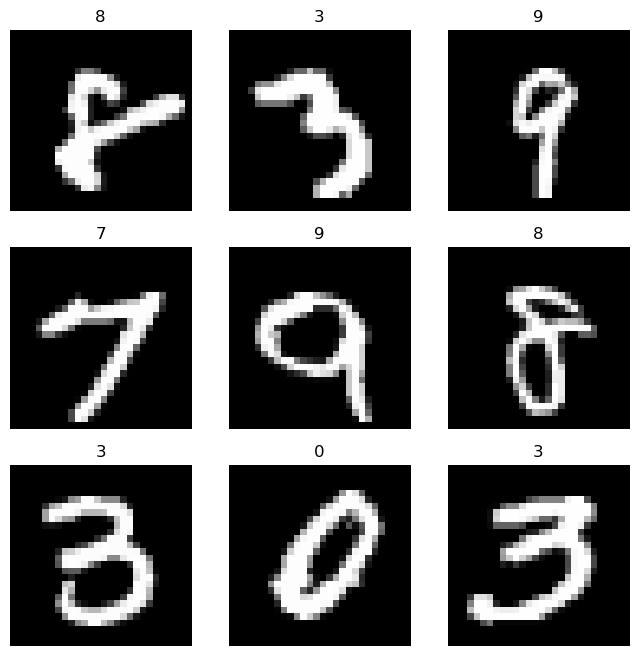

In [295]:
plot_mnist_sklearn(X_train, y_train)

### Attempt 1: Fourier features
##### Made by: Hector Ramirez

Here are two helper functions that we will use throughout the notebook to compute a loss metric.

In [25]:
def zero_one_loss_metric(y_true, y_pred):
    '''
    Returns the percentage of misclassifications
    :param y_true: ground truth (correct) labels
    :param y_pred: predicted labels, as returned by a classifier
    :return: the zero-one classification loss
    '''
    return zero_one_loss(y_true, y_pred)*100

def mean_squared_error_metric(y_true, y_pred):
    '''
    Returns the mean squared error regression loss
    :param y_true: ground truth (correct) labels
    :param y_pred: predicted labels, as returned by a classifier
    :return: the mean squared error regression loss
    '''
    return mean_squared_error(y_true, y_pred)

In [10]:
# I will start with Random Features as it is also an approximation of the kernel trick

### Define the sigmoid function
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#d = dim of the column vector x
#D is the number of features wanted in the output
def u_vectors(X_test, X_train ,D):
    """_summary_
    Args:
        X (matrix): Data matrix to transform dim (n,d)
        D int: Number of features wanted in the output

    Returns:
        u_test (matrix): matrix of the new features dim (n,D)
        u_train (matrix): matrix of the new features dim (n,D)
    """
    ## the d is the number of columns of X
    d= X_test.shape[1]
    F = np.random.normal(0,1/np.sqrt(d),(D, d))
    # I have to use the same F for the test and the train set to be consistent
    u_test = np.zeros((X_test.shape[0],D))
    u_train = np.zeros((X_train.shape[0],D))
    # Generating the new test set 
    for i in range(X_test.shape[0]):
        u_test[i,:] = (1/np.sqrt(D))*sigmoid(F@X_test[i])
    # Generating the training set 
    for j in range(X_train.shape[0]):
        u_train[j,:] = (1/np.sqrt(D))*sigmoid(F@X_train[j])
    
    return u_test, u_train

In [11]:
def to_random_features(training_set, test_set, D):
    X_train = training_set.data.numpy().reshape(training_set.data.shape[0],-1)
    X_test = test_set.data.numpy().reshape(test_set.data.shape[0],-1)
    y_train = training_set.targets.numpy()
    y_test = test_set.targets.numpy()
    u_test, u_train = u_vectors(X_test, X_train, D)
    #Transform sets to numpy arrays
    #store the labels and the images in two different arrays
    #I can use the same training set for the test set as
    # validation set and let sk learn do the splitting
    
    return u_train, y_train, u_test, y_test

In [12]:
# First I will make sure it works with a small number of features
D = 100
X_train, y_train, X_test, y_test = to_random_features(
    training_dataset,
    test_dataset,
    D)

In [13]:
def train_model(X_test, X_train, y_test, y_train):
    lsc = LinearRegression(fit_intercept=True, normalize=False, copy_X=True, n_jobs=None)
    lsc.fit(X_train, y_train)
    
    clf = LogisticRegression(random_state=0, max_iter=1000, multi_class='multinomial')
    clf.fit(X_train, y_train)
    

    test_error = 1 - clf.score(X_test, y_test)
    train_error = 1 - clf.score(X_train, y_train)
    print("Accuracy on the test set: ", clf.score(X_test, y_test))
    print("Accuracy on the training set: ", clf.score(X_train, y_train))
    
    weights = clf.coef_
    norm = np.linalg.norm(weights, axis=1).mean()
    number_of_features = X_train.shape[1]
    print("number of features: ", number_of_features)
    
     # find training loss
    zero_one_train_loss = zero_one_loss_metric(y_train, clf.predict(X_train))
    mse_train_loss = mean_squared_error_metric(y_train, lsc.predict(X_train))
    #mse_train_loss = mean_squared_error_metric(one_hot_encode(y_train), one_hot_encode(clf.predict(X_train)))
    
    # find testing loss
    zero_one_test_loss = zero_one_loss_metric(y_test, clf.predict(X_test))   
    mse_test_loss = mean_squared_error_metric(y_test, lsc.predict(X_test))
    #mse_test_loss = mean_squared_error_metric(one_hot_encode(y_test), one_hot_encode(clf.predict(X_test)))
    
    return number_of_features, zero_one_train_loss, zero_one_test_loss, mse_train_loss, mse_test_loss, norm

In [14]:
Random_features = np.linspace(1000, 20000, 15, dtype=int)
#Random_features = np.append(Random_features, [30000, 40000, 50000, 60000])
train_loss = []
test_loss = []

Random_features

array([ 1000,  2357,  3714,  5071,  6428,  7785,  9142, 10500, 11857,
       13214, 14571, 15928, 17285, 18642, 20000])

In [15]:
RF_df = pd.DataFrame(columns=['Number of features', 'Test error', 'Train error', 'Norm of the weights'])

for D in tqdm(Random_features, desc="Random Features"):
    X_train, y_train, X_test, y_test = to_random_features(
    training_dataset,
    test_dataset,
    int(D))
    
    number_of_features, zero_one_train_loss, zero_one_test_loss, mse_train_loss, mse_test_loss, norm = train_model(X_test, X_train, y_test, y_train)
    
    
    RF_df = RF_df.append(
        {'Number of features': number_of_features,
         'Zero one train Test error': zero_one_test_loss,
         'Zero one Train error': zero_one_train_loss,
         'Square train Test error': mse_test_loss,
         'Square Train error': mse_train_loss,
         'Norm of the weights': norm},
        ignore_index=True)
    # train_loss.append(train_error)
    # test_loss.append(test_error)
    
RF_df.to_csv('Random_features.csv')

Random Features:   0%|          | 0/15 [00:00<?, ?it/s]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9219
Accuracy on the training set:  0.9224
number of features:  1000


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:   7%|▋         | 1/15 [00:23<05:32, 23.77s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9289
Accuracy on the training set:  0.9296333333333333
number of features:  2357


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  13%|█▎        | 2/15 [01:12<08:21, 38.61s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.931
Accuracy on the training set:  0.93135
number of features:  3714


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  20%|██        | 3/15 [02:33<11:32, 57.70s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9311
Accuracy on the training set:  0.9315
number of features:  5071


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  27%|██▋       | 4/15 [04:24<14:29, 79.03s/it]C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\1457717485.py:5: RuntimeWarning: overflow encountered in exp
  return 1 / (1 + np.exp(-x))
c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9308
Accuracy on the training set:  0.9327333333333333
number of features:  6428


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  33%|███▎      | 5/15 [07:31<19:36, 117.66s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9333
Accuracy on the training set:  0.9334666666666667
number of features:  7785


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  40%|████      | 6/15 [11:51<24:54, 166.06s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9335
Accuracy on the training set:  0.9335
number of features:  9142


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  47%|████▋     | 7/15 [17:28<29:36, 222.12s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9332
Accuracy on the training set:  0.9337833333333333
number of features:  10500


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  53%|█████▎    | 8/15 [25:23<35:18, 302.60s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9329
Accuracy on the training set:  0.9337333333333333
number of features:  11857


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  60%|██████    | 9/15 [35:35<39:55, 399.29s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9323
Accuracy on the training set:  0.93395
number of features:  13214


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  67%|██████▋   | 10/15 [52:06<48:30, 582.05s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9333
Accuracy on the training set:  0.9342666666666667
number of features:  14571


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  73%|███████▎  | 11/15 [1:11:39<50:51, 762.82s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9332
Accuracy on the training set:  0.9343833333333333
number of features:  15928


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  80%|████████  | 12/15 [1:40:11<52:34, 1051.54s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9341
Accuracy on the training set:  0.9338333333333333
number of features:  17285


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  87%|████████▋ | 13/15 [2:22:58<50:21, 1510.56s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.934
Accuracy on the training set:  0.9336333333333333
number of features:  18642


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features:  93%|█████████▎| 14/15 [3:22:16<35:29, 2129.01s/it]c:\Users\hecma\anaconda3\lib\site-packages\sklearn\linear_model\_base.py:148: FutureWarning: 'normalize' was deprecated in version 1.0 and will be removed in 1.2. Please leave the normalize parameter to its default value to silence this warning. The default behavior of this estimator is to not do any normalization. If normalization is needed please use sklearn.preprocessing.StandardScaler instead.
  warnings.warn(


Accuracy on the test set:  0.9339
Accuracy on the training set:  0.9341833333333334
number of features:  20000


C:\Users\hecma\AppData\Local\Temp\ipykernel_38616\3814032013.py:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  RF_df = RF_df.append(
Random Features: 100%|██████████| 15/15 [4:12:37<00:00, 1010.49s/it]


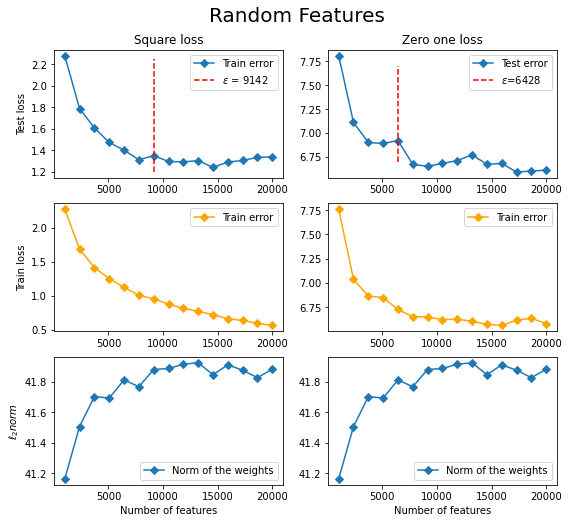

In [75]:
RF_df = pd.read_csv('Random_features.csv')
norm = RF_df['Norm of the weights']

figure, axs = plt.subplots(3, 2, figsize=(9, 8))
figure.suptitle("Random Features", fontsize=20, y= 0.955)
plt.subplot(3, 2, 1).set_title("Square loss")
plt.subplot(3, 2, 1).set_ylabel("Test loss")
plt.subplot(3, 2, 3).set_ylabel("Train loss")
plt.subplot(3, 2, 5).set_ylabel("$\ell_2 norm$")
axs[0,0].plot(RF_df['Number of features'], RF_df['Square train Test error'], label="Train error", marker='D')
axs[0,0].vlines(9142, 1.2, 2.25, linestyles='dashed', colors='red', label=f"$\epsilon$ = {9142}")
axs[0,0].legend()
axs[1,0].plot(RF_df['Number of features'], RF_df['Square Train error'], label="Train error", color="orange", marker='D')
axs[1,0].legend()
axs[2,0].plot(RF_df['Number of features'], RF_df['Norm of the weights'], label="Norm of the weights", marker='D')
axs[2,0].legend()

plt.subplot(3, 2, 2).set_title("Zero one loss")
axs[0,1].plot(RF_df['Number of features'], RF_df['Zero one train Test error'], label="Test error", marker='D')
axs[0,1].vlines(6428, 6.7, 7.7, linestyles='dashed', colors='red',label=f"$\epsilon$={6428}")
axs[0,1].legend()
axs[1,1].plot(RF_df['Number of features'], RF_df['Zero one Train error'], label="Train error", color="orange", marker='D')
axs[1,1].legend()
axs[2,1].plot(RF_df['Number of features'], RF_df['Norm of the weights'], label="Norm of the weights", marker='D')
axs[2,1].legend()
plt.subplot(3, 2, 5).set_xlabel("Number of features")
plt.subplot(3, 2, 6).set_xlabel("Number of features")
plt.show()




### Attempt 2: Neural Network

We start by turning a subset of the datasets into train and test dataloaders. 

In [13]:
train_dataloader = DataLoader(training_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size = 128, shuffle=True)

# Subset the training set to 20000 samples
train_subset = Subset(train_dataloader.dataset, np.arange(0, 20000))
test_subset = Subset(test_dataloader.dataset, np.arange(0, 5000))

# Create the dataloaders
train_loader = DataLoader(train_subset, batch_size = 128, shuffle=True, num_workers=2)
test_loader = DataLoader(test_subset, batch_size = 128, shuffle=True, num_workers=2)

In [14]:
print("Number of training samples: ", len(train_subset))
print("Number of test samples: ", len(test_subset))
print("Number of batches in the training set: ", len(train_loader))
print("Number of batches in the test set: ", len(test_loader))

Number of training samples:  20000
Number of test samples:  5000
Number of batches in the training set:  157
Number of batches in the test set:  40


Now, we define two two-layer neural network models, one to be used for observing the MSE loss and the other for observing the CrossEntropy loss.

In [15]:
# define the neural network architecture that we will use for the classification task and minimize the MSE loss
class NeuralNetworkMSE(nn.Module):
    def __init__(self, current_count, param, constant, hidden_layer_size):
        super(NeuralNetworkMSE, self).__init__()
        print(f'MSE: Neural Network with {hidden_layer_size} hidden units')
        self.input_layer = nn.Linear(28*28, hidden_layer_size)
        self.hidden_layer = nn.Linear(hidden_layer_size, 1)
    
    def forward(self, x):
        d = 784
        x = x.view(-1, d)
        x = F.relu(self.input_layer(x))
        x = self.hidden_layer(x)
        return x


In [17]:
# define the neural network architecture that we will use for the classification task and minimize the cross entropy loss
class NeuralNetworkCross(nn.Module):
    def __init__(self, current_count, param, constant, hidden_layer_size):
        super(NeuralNetworkCross, self).__init__()
        print(f'CrossEntropy: Neural Network with {hidden_layer_size} hidden units')
        self.input_layer = nn.Linear(28*28, hidden_layer_size)
        self.hidden_layer = nn.Linear(hidden_layer_size, 10)
    
    def forward(self, x):
        d = 784
        x = x.view(-1, d)
        x = F.relu(self.input_layer(x))
        x = self.hidden_layer(x)
        return x

In [19]:
# find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cpu


We use the following functions to train the models and observe the loss.

In [20]:
def train_epoch(model: nn.Module, train_dataloader: DataLoader, 
                optimizer: torch.optim.Optimizer, device: torch.device,
                loss_type: str):
    '''
    Train the model for one epoch.
    :param model: The model to train
    :param train_dataloader: The dataloader to use for training
    :param optimizer: The optimizer to use for training
    :param: device: The device to use for training
    :param: loss_type: The loss function to use for training, either "MSE" or "CrossEntropy"
    :return: The loss for the epoch
    '''

    # train
    model = model.to(device)
    model.train()
    running_loss = 0.0

    for batch_idx, (data, target) in enumerate(train_dataloader,0):

        # move data and target to device
        if loss_type == "MSE":
            data, target = data.to(device), target.to(torch.float32).to(device)
        else:
            data, target = data.to(device), target.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # do the forward pass
        output = model(data)

        # compute the loss
        if loss_type == "MSE":
            lossmse = nn.MSELoss()
            loss = lossmse(output, target.view(-1,1))
        else:
            losscross = nn.CrossEntropyLoss()
            loss = losscross(output, target)

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()

        running_loss += loss.item()
        
    return running_loss / len(train_dataloader.dataset)


def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    test_dataloader: DataLoader,
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    loss_type: str):
    '''
    Call the train_epoch() method and predict() method for a specified number of epochs.
    :param model: The model to train/test
    :param train_dataloader: The dataloader to use for training
    :param test_dataloader: The dataloader to use for testing
    :param optimizer: The optimizer to use for training
    :param epochs: The number of epochs to train/test for
    :param device: The device to use for training/testing
    :param loss_type: The loss function to use for training, either "MSE" or "CrossEntropy"
    :return: The training and testing losses for each epoch
    '''

    # Train for numerous epochs:
    train_loss = []
    test_loss = []

    for epoch in range(epochs):
        train_losses = train_epoch(model=model, train_dataloader=train_dataloader, optimizer=optimizer, device=device, loss_type=loss_type)
        train_loss.append(train_losses)
        
        test_losses = predict(model=model, test_dataloader=test_dataloader, optimizer=optimizer, device=device, loss_type=loss_type)
        test_loss.append(test_losses)

    return train_loss, test_loss


def predict(model: nn.Module, test_dataloader: DataLoader, optimizer: torch.optim.Optimizer, device: torch.device, loss_type: str):
    '''
    Test the model.
    :param model: The model to test
    :param test_dataloader: The dataloader to use for testing
    :param optimizer: The optimizer to use for testing
    :param device: The device to use for testing
    :param loss_type: The loss function to use for training, either "MSE" or "CrossEntropy"
    :return: The loss for the epoch
    '''
    model = model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            # move data and target to device
            if loss_type == "MSE":
                data, target = data.to(device), target.to(torch.float32).to(device)
            else:
                data, target = data.to(device), target.to(device)

            # do the forward pass
            output = model(data)

            # compute the loss
            if loss_type == "MSE":
                lossmse = nn.MSELoss()
                loss = lossmse(output, target.view(-1,1))
            else:
                losscross = nn.CrossEntropyLoss()
                loss = losscross(output, target)
     
            test_loss += loss.item()

    return test_loss / len(test_dataloader.dataset)

The following function computes the size of the hidden layer of the model, where the number of parameters is given with $(d+1) \cdot H + (H+1) \cdot K$, where $H$ is the number of hidden units, $K$ is the number of classes and $d$ is the feature dimension.

In [22]:
def compute_hidden_layer_size(param, index, constant, num_classes = 10):
    '''
    Compute the hidden layer size for a given number of parameters.
    :param param: A list of the number of parameters for each layer
    :param index: The index of the current layer
    :param constant: The constant to use for computing the hidden layer size, but param[index] * constant = number of parameters
    :param num_classes: The number of classes in the dataset
    :return: The hidden layer size
    '''
    d = 784
    K = num_classes
    H = (param[index] * constant - K)// (d + 1 + K)
    return H

Now, we train the models and observe the two losses as the number of parameters grows by plotting .

In [261]:
x_axis = []
models_MSE = []
models_Cross = []

param = np.array([3, 7, 15, 20, 27, 33,  40, 53, 60, 64, 70, 75, 80, 86, 90, 97])
index = 0
constant = 10**3

# initialize a dictionary to store the losses
loss_dict = {'train': [], 'test': [], 'train_cross': [], 'test_cross': [], 'parameter_count': []}

while index < len(param):
    H = compute_hidden_layer_size(param, index, constant)
    x_axis.append(H)
    modelMSE = NeuralNetworkMSE(index, param, constant, H)
    modelMSE = modelMSE.to(DEVICE)

    modelCross = NeuralNetworkCross(index, param, constant, H)
    modelCross = modelCross.to(DEVICE)
    
    optimizerMSE = optim.SGD(modelMSE.parameters(), lr=0.01, momentum=0.95)
    optimizerCross = optim.SGD(modelCross.parameters(), lr=0.01, momentum=0.95)
    
    train_loss, test_loss = fit(model = modelMSE, train_dataloader = train_loader, 
                                test_dataloader = test_loader, optimizer = optimizerMSE, 
                                epochs=50, device=DEVICE, loss_type = "MSE")
    train_loss_cross, test_loss_cross = fit(model = modelCross, train_dataloader = train_loader, 
                                            test_dataloader = test_loader, optimizer = optimizerCross, 
                                            epochs=50, device=DEVICE, loss_type = "Cross")

    models_MSE.append(modelMSE)
    models_Cross.append(modelCross)
    
    loss_dict['train'] = np.append(loss_dict['train'], train_loss[-1])
    loss_dict['test'] = np.append(loss_dict['test'], test_loss[-1])
    loss_dict['train_cross'] = np.append(loss_dict['train_cross'], train_loss_cross[-1])
    loss_dict['test_cross'] = np.append(loss_dict['test_cross'], test_loss_cross[-1])
    loss_dict['parameter_count'] = np.append(loss_dict['parameter_count'], param[index])
    index += 1

Neural Network with 3 hidden units
Neural Network with 3 hidden units
Neural Network with 5 hidden units
Neural Network with 5 hidden units
Neural Network with 8 hidden units
Neural Network with 8 hidden units
Neural Network with 12 hidden units
Neural Network with 12 hidden units
Neural Network with 18 hidden units
Neural Network with 18 hidden units
Neural Network with 25 hidden units
Neural Network with 25 hidden units


In [23]:
def number_parameters(model):
    ''' 
    Returns the number of parameters in a model
    :param model: The model to compute the number of parameters for
    :return: The number of parameters in the model
    '''
    nump=0
    for p in list(model.parameters()):
        a=1
        for b in list(p.size()):
            a = a*b
        nump += a
    return nump

In [ ]:
params_MSE = []
params_Cross = []
for i in range(len(param)):
  params_MSE.append(number_parameters(models_MSE[i]))
  params_Cross.append(number_parameters(models_Cross[i]))

In [263]:
def plot_NN(result_dict):
    '''
    Plot the double descent curve for the Neural Network model
    :param result_dict: The dictionary containing the results
    '''
    fig, ax = plt.subplots(figsize=(8, 6), sharey = True)

    plt.subplot(2,1,1)
    plt.title(f'Neural network model: Double descent curve')
    plt.plot(params_MSE, result_dict['train'], 
             color='tab:orange', label = 'Train')             
    plt.plot(params_MSE, result_dict['test'], 
             color='tab:blue', label = 'Test')
    plt.ylabel('Squared loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(params_Cross, result_dict['train_cross'], 
             color='tab:orange', label = 'Train')
    plt.plot(params_Cross, result_dict['test_cross'], 
             color='tab:blue', label = 'Test')
    plt.ylabel('Cross-entropy loss')
    plt.xlabel('Model parameters')

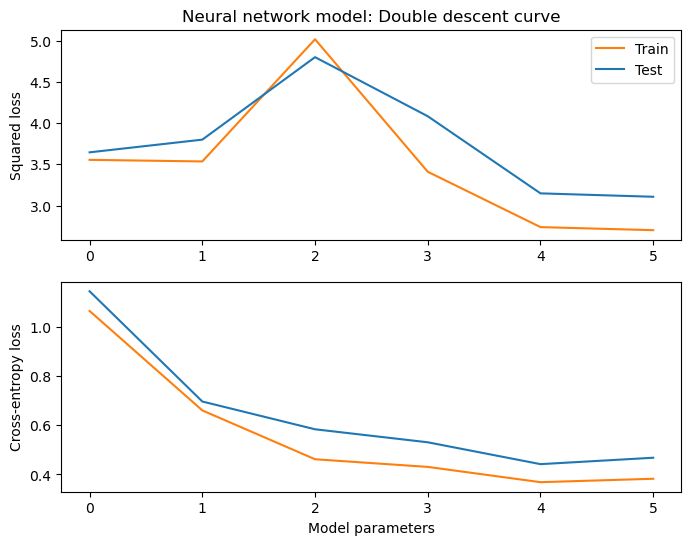

In [264]:
plot_NN(loss_dict)

### Attempt 3: Random Forests

First, we define a helper function to represent categorical variables as one-hot vectors.

In [27]:
def one_hot_encode(data, classes=10):
    '''
    Represent categorical variables as binary vectors (one-hot encoding).
    :param data: an array that we perform the One Hot Encoding on, i.e., we transform each datapoint to a binary vector
    :param classes: number of classes we aim to identify in the dataset
    :return: a numpy array with the one-hot encoded data
    '''
    onehot_encoded = []
    for value in data:
        a = np.array([0] * classes)
        a[int(value)] = 1
        onehot_encoded.append(a)
        
    return np.stack(onehot_encoded)

Now, we can define the function that will train the Random Forest model for a various number of trees and maximum leaf nodes, and returns a dictionary that stores the losses.

In [28]:

def double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100, 
                      X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):
    '''
    Train a Random Forest Classifier over several different values of the parameters number of trees (N_tree)
    and the maximum number of leaves allowed for each tree (N_max_leaf)
    :param tree_bound: the upper bound for N_tree
    :param leaves_bound: the upper bound for N_max_leaf
    :param tree_step: the step for N_tree
    :param leaves_step: the step for N_max_leaf
    :param X_train: the train data 
    :param y_train: the train targets
    :param X_test: the test data
    :param y_test: the test targets
    :return: result_dict
    '''

    # we initialize the model with N_tree = 1 and N_max_leaf = 10
    N_max_leaves = 10
    N_tree = 1
    model = RandomForestClassifier(n_estimators=N_tree, 
                                   bootstrap=False, 
                                   criterion='gini', 
                                   max_leaf_nodes=N_max_leaves,
                                   max_features='sqrt',
                                   max_depth = None)
    
    leaf_sizes = []
    trees = []

    # initialize training losses
    zero_one_train_losses = []
    mse_train_losses = []
    
    # initialize testing losses
    zero_one_test_losses = []
    mse_test_losses = []

    while N_max_leaves <= leaves_bound:

        model.fit(X_train, y_train)
        
        # find training loss
        zero_one_train_loss = zero_one_loss_metric(y_train, model.predict(X_train))
        mse_train_loss = mean_squared_error_metric(one_hot_encode(y_train), one_hot_encode(model.predict(X_train)))
        
        # find testing loss
        zero_one_test_loss = zero_one_loss_metric(y_test, model.predict(X_test))   
        mse_test_loss = mean_squared_error_metric(one_hot_encode(y_test), one_hot_encode(model.predict(X_test)))
        
        # add training and testing loss to the training and testing losses arrays
        zero_one_train_losses = np.append(zero_one_train_losses, zero_one_train_loss)
        mse_train_losses = np.append(mse_train_losses, mse_train_loss)
        
        zero_one_test_losses = np.append(zero_one_test_losses, zero_one_test_loss)
        mse_test_losses = np.append(mse_test_losses, mse_test_loss)

        leaf_sizes.append(N_max_leaves)
        trees.append(N_tree)
        
        if (N_max_leaves == 10):
            N_max_leaves = leaves_step
        else:
            N_max_leaves += leaves_step
                
        # define the model for every new value of N_max_leaves  
        model = RandomForestClassifier(n_estimators=N_tree, 
                                       bootstrap=False, 
                                       criterion='gini', 
                                       max_leaf_nodes=N_max_leaves,
                                       max_features='sqrt',
                                       max_depth = None)

    N_max_leaves = N_max_leaves - leaves_step
                
    while N_tree <= tree_bound:
            
        # define the model for every new value of N_tree
        model = RandomForestClassifier(n_estimators=N_tree, 
                                       bootstrap=False, 
                                       criterion='gini', 
                                       max_leaf_nodes=N_max_leaves,
                                       max_features='sqrt',
                                       max_depth = None)
        
        model.fit(X_train, y_train)

        # find training loss
        zero_one_train_loss = zero_one_loss_metric(y_train, model.predict(X_train))
        mse_train_loss = mean_squared_error_metric(one_hot_encode(y_train), one_hot_encode(model.predict(X_train)))
        
        # find testing loss
        zero_one_test_loss = zero_one_loss_metric(y_test, model.predict(X_test))   
        mse_test_loss = mean_squared_error_metric(one_hot_encode(y_test), one_hot_encode(model.predict(X_test)))

        # add training and testing loss to the training and testing losses arrays
        zero_one_train_losses = np.append(zero_one_train_losses, zero_one_train_loss)
        mse_train_losses = np.append(mse_train_losses, mse_train_loss)
        
        zero_one_test_losses = np.append(zero_one_test_losses, zero_one_test_loss)
        mse_test_losses = np.append(mse_test_losses, mse_test_loss)

        leaf_sizes.append(N_max_leaves)
        trees.append(N_tree)
            
        N_tree += tree_step
            
    result_dict = {'zero_one_train_loss': zero_one_train_losses, 
                   'mse_train_loss': mse_train_losses, 
                   'zero_one_test_loss': zero_one_test_losses,
                   'mse_test_loss': mse_test_losses,
                   'leaf_sizes': np.array(leaf_sizes), 
                   'trees': np.array(trees)}    
    
    return result_dict



In [51]:
# call double_descent_RF and return the result dictionary
result_RF = double_descent_RF(tree_bound = 20, leaves_bound = 2000, tree_step = 1, leaves_step = 100,
                        X_train= X_train, y_train=y_train, X_test=X_test, y_test=y_test)

pd.DataFrame(result_RF).to_csv('RandomForest.csv')


In [70]:
def plot_RF(result_dict):
    '''
    Plot the double descent curve for the Random Forest Classifier
    :param result_dict: the returned dictionary from the double_descent_RF function
    '''
    fig = plt.figure(figsize=(10, 8))
    plt.rcParams.update({'font.size': 14})
    #define xticks
    tick_location = [0, 10, 20, 30, 40]
    tick_label = ['10 / 1', '1000 / 1', '2000 / 1', '2000 / 10', '2000 / 20']

    plt.subplot(2,1,1)
    plt.title(f'Random Forest model: Double descent curve')
    plt.plot(range(len(result_dict['mse_train_loss'])), result_dict['mse_train_loss'], 
             color='tab:orange', label = 'Train')
    plt.plot(range(len(result_dict['mse_test_loss'])), result_dict['mse_test_loss'], 
             color='tab:blue', label = 'Test')
    plt.axvline(20, color = "black", linestyle='dashed')
    plt.ylabel('Squared loss')
    plt.xticks(tick_location, [])
    plt.ylim(-0.001, 0.07)
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(range(len(result_dict['zero_one_train_loss'])), result_dict['zero_one_train_loss'], 
             color='tab:orange', label = 'Train')
    plt.plot(range(len(result_dict['zero_one_test_loss'])), result_dict['zero_one_test_loss'], 
             color='tab:blue', label = 'Test')
    plt.axvline(20, color = "black", linestyle='dashed')
    plt.ylabel('Zero-one loss (%)')
    plt.xlabel('Model parameters: $N_{leaf}^{max}$ / $N_{tree}$')
    plt.ylim(-0.5, 35)
    plt.xticks(tick_location, tick_label)


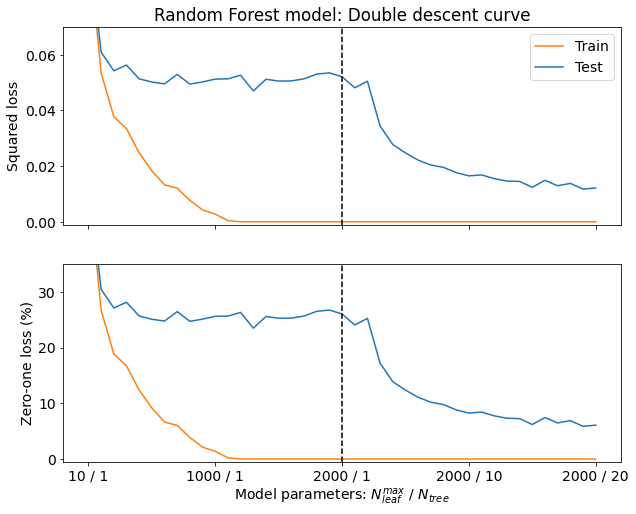

In [72]:
fig = plot_RF(result_RF)
# save figure
plt.savefig('RF_double_descent.png', dpi=300)